In [2]:
# Import python libraries
import os
import sys
import time
import pandas as pd
import numpy as np
import urllib.request

import matplotlib.pyplot as plt
import seaborn as sns
import chart_studio.plotly as py
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings

## Part 0 - Set up PySpark

In [3]:
# Use findspark
import findspark
findspark.init()

In [4]:
os.environ['PYSPARK_PYTHON'] = "python3"

In [5]:
# Create SparkSession and sparkcontext
from pyspark.sql import SparkSession
spark = SparkSession.builder\
                    .master("local[*]")\
                    .appName('Crime Data Analysis')\
                    .getOrCreate()
sc=spark.sparkContext

22/06/26 09:00:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [66]:
# Import the PySPark libraries
from pyspark.sql.functions import to_date, hour, month, year, date_format, col, regexp_replace, lit, count

In [7]:
sc.applicationId

'local-1656214255728'

## Part 1 - Data Collection

In [8]:
def report(count, block_size, total_size):
    global start_time
    if count == 0:
        start_time = time.time()
        return
    duration = time.time() - start_time
    progress_size = int(count * block_size)
    speed = int(progress_size / (1024 * duration))
    percent = int(count * block_size * 100 / total_size)
    sys.stdout.write("%d MB, %d KB/s, %d seconds passed, %d total size" %
                    (percent, progress_size / (1024 * 1024), speed, duration, total_size))
    sys.stdout.flush()

In [9]:
# Define the data file path and file name
data_download_path = os.path.join(os.getcwd(), "data")
data_file = os.path.join(data_download_path, "sf_crime_data.csv")

In [10]:
# urllib.request.urlretrieve("https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD", data_file, reporthook=report)

## Part 3 - Prepare Data

In [11]:
# crime_data_lines = sc.textFile(data_file)
crime_sdf = spark.read.format("csv").options(header=True, infer_schema=True).load(data_file)

In [12]:
# Print schema of the dataframe
crime_sdf.printSchema()

root
 |-- PdId: string (nullable = true)
 |-- IncidntNum: string (nullable = true)
 |-- Incident Code: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: string (nullable = true)
 |-- Y: string (nullable = true)
 |-- location: string (nullable = true)
 |-- SF Find Neighborhoods 2 2: string (nullable = true)
 |-- Current Police Districts 2 2: string (nullable = true)
 |-- Current Supervisor Districts 2 2: string (nullable = true)
 |-- Analysis Neighborhoods 2 2: string (nullable = true)
 |-- DELETE - Fire Prevention Districts 2 2: string (nullable = true)
 |-- DELETE - Police Districts 2 2: string (nullable = true)
 |-- DELETE - Supervisor Districts 2 2: string (nullable = true)
 |-- DELETE - Z

In [13]:
# Select the columns from dataframe which are required for analysis
cols = ['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', \
        'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location', 'PdId']

df = crime_sdf.select(*cols)

In [14]:
# Get the total number of data 
df.count()

2129525

In [15]:
# Show data sample
df.limit(3).toPandas()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,031147516,LARCENY/THEFT,PETTY THEFT FROM A BUILDING,Sunday,09/28/2003,10:00,SOUTHERN,NONE,1ST ST / BRANNAN ST,-120.5,90,POINT (-120.50000000000001 90),3114751606302
1,050697011,ASSAULT,BATTERY,Wednesday,06/22/2005,12:20,NORTHERN,NONE,1200 Block of EDDY ST,-122.428223303176,37.7818959488603,POINT (-122.42822330317601 37.7818959488603),5069701104134
2,060747292,ASSAULT,ASSAULT,Saturday,07/15/2006,00:55,CENTRAL,NONE,1600 Block of POWELL ST,-122.410672425337,37.799788690123,POINT (-122.41067242533701 37.799788690123),6074729204104


#### Fix Location column values

In [16]:
# Current values
df.select(col("Location")).limit(3).show(truncate=False)

+--------------------------------------------+
|Location                                    |
+--------------------------------------------+
|POINT (-120.50000000000001 90)              |
|POINT (-122.42822330317601 37.7818959488603)|
|POINT (-122.41067242533701 37.799788690123) |
+--------------------------------------------+



Remove `POINT ` and replace space between `longitude` and `latitude` values with comma `,`

In [17]:
df = df.withColumn('Location', regexp_replace('Location', 'POINT ', '')) \
    .withColumn('Location', regexp_replace('Location', ' ', ','))

In [18]:
# After fix
df.select(col("Location")).limit(3).show(truncate=False)

+--------------------------------------+
|Location                              |
+--------------------------------------+
|(-120.50000000000001,90)              |
|(-122.42822330317601,37.7818959488603)|
|(-122.41067242533701,37.799788690123) |
+--------------------------------------+



### Convert date format

In [19]:
# Convert MM/dd/yyyy to yyyy-MM-dd using to_date
df = df.withColumn("Date", to_date('Date', 'MM/dd/yyy'))

In [20]:
df.select(col("Date")).limit(5).show()

+----------+
|      Date|
+----------+
|2003-09-28|
|2005-06-22|
|2006-07-15|
|2007-09-25|
|2011-09-24|
+----------+



In [21]:
df.select(year(col("Date"))).distinct().collect()

[Row(year(Date)=2003),
 Row(year(Date)=2007),
 Row(year(Date)=2018),
 Row(year(Date)=2015),
 Row(year(Date)=2006),
 Row(year(Date)=2013),
 Row(year(Date)=2014),
 Row(year(Date)=2004),
 Row(year(Date)=2012),
 Row(year(Date)=2009),
 Row(year(Date)=2016),
 Row(year(Date)=2005),
 Row(year(Date)=2010),
 Row(year(Date)=2011),
 Row(year(Date)=2008),
 Row(year(Date)=2017)]

## Part 4 - EDA

### OLAP 1.1 
Count the number of crimes for different category.

In [22]:
# Top 5 most frequent crimes in SF
df_t5_crime = df.groupBy("Category").count().orderBy("count", ascending=False).limit(5).toPandas()

Instead of creating table and plot separately 
```python
px.bar(df_t5_crime, x="Category", y="count", title="Top 5 most frequent crimes in SF")
ff.create_table(df_t5_crime)
```

Created subplot with table and bar plot together.

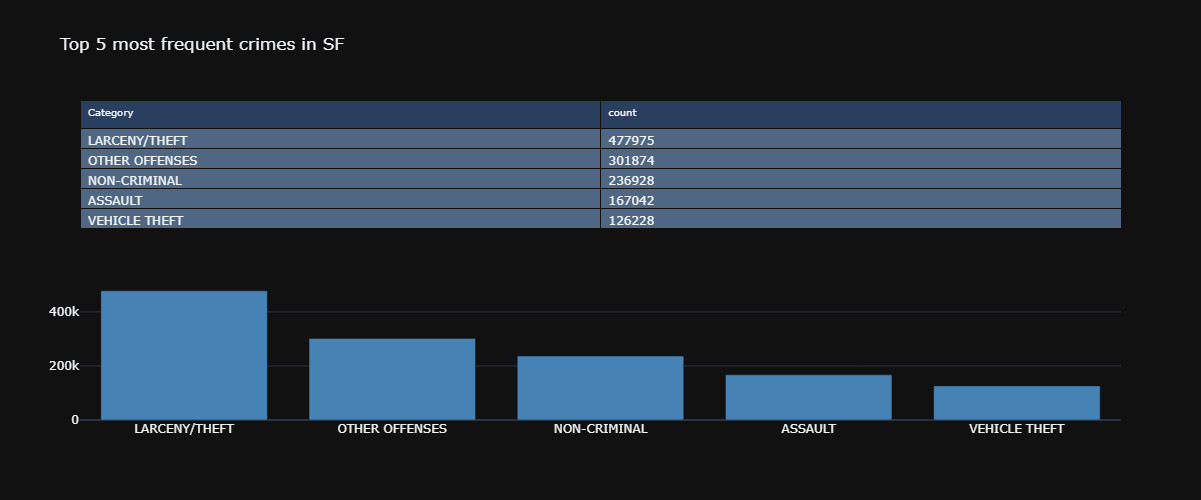

In [57]:
# Prepare chart for the category crime count
fig = make_subplots(rows=2, cols=1, shared_xaxes=False, specs=[[{"type": "table"}],[{"type": "bar"}]])

fig.add_trace(
    go.Table(
        header=dict(
            values=list(df_t5_crime.columns),
            font=dict(size=10),
            align="left"
        ),
        cells=dict(
            values=[df_t5_crime[k].tolist() for k in df_t5_crime.columns],
            align = "left")
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=df_t5_crime['Category'], y=df_t5_crime['count'], marker_color="steelblue"),
    row=2, col=1
)

fig.update_layout(
    template='plotly_dark',
    height=500,
    showlegend=False,
    title_text="Top 5 most frequent crimes in SF"
)

fig.show()

### OLAP 1.2
Count the number of crimes for different district.

In [24]:
# Prepare data for the district crime count
df_t5_district = crime_sdf.groupBy("PdDistrict").count().orderBy("count", ascending=False).toPandas()

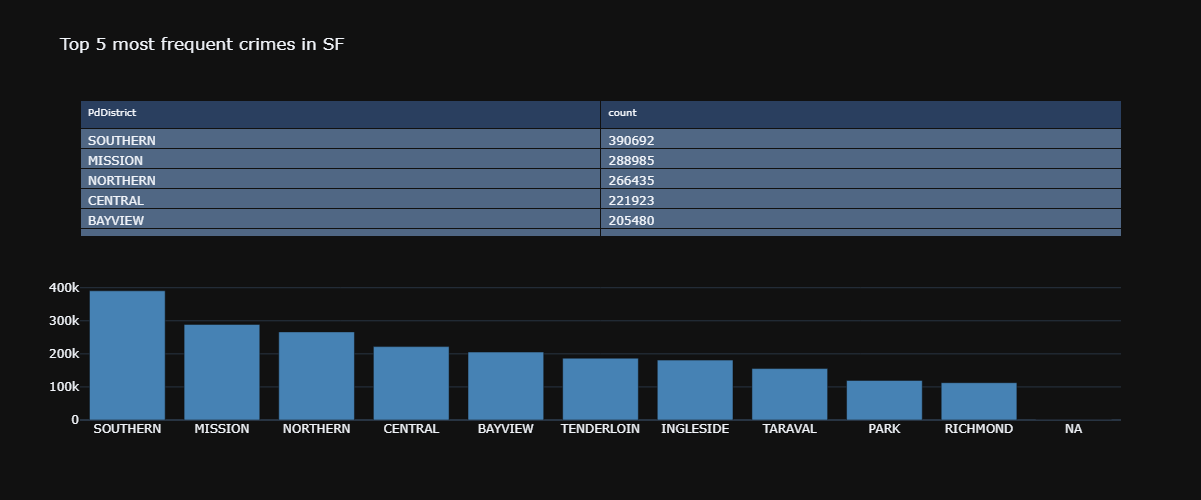

In [56]:
# Top district crime count
fig = make_subplots(rows=2, cols=1, shared_xaxes=False, specs=[[{"type": "table"}],[{"type": "bar"}]])

fig.add_trace(
    go.Table(
        header=dict(
            values=list(df_t5_district.columns),
            font=dict(size=10),
            align="left"
        ),
        cells=dict(
            values=[df_t5_district[k].tolist() for k in df_t5_district.columns],
            align = "left")
    ),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=df_t5_district['PdDistrict'], y=df_t5_district['count'], marker_color="steelblue"),
    row=2, col=1
)

fig.update_layout(
    template='plotly_dark',
    height=500,
    showlegend=False,
    title_text="Top 5 most frequent crimes in SF"
)

fig.show()

### OLAP 1.3 
Count the number of crimes each "Sunday" at "SF downtown".

NOTE: SF downtown is defiend via the range of spatial location. For example, you can use a rectangle to define the SF downtown, or you can define a cicle with center as well. Thus, you need to write your own UDF function to filter data which are located inside certain spatial range. You can follow the example here: https://changhsinlee.com/pyspark-udf/

In [26]:
# Filter date by Sunday
df_sunday = df.filter(col("DayOfWeek") == "Sunday")

In [27]:
# Convert the longitude and latitude to double
df_sunday = df_sunday.withColumn('X', col('X').cast('double')).withColumn('Y', col('Y').cast('double'))

In [28]:
# Display the schema of table - X & Y should be double instead of string
df_sunday.printSchema()

root
 |-- IncidntNum: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Descript: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Time: string (nullable = true)
 |-- PdDistrict: string (nullable = true)
 |-- Resolution: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- X: double (nullable = true)
 |-- Y: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- PdId: string (nullable = true)



In [29]:
# Extract the geogrophical information to distinguish if it is downtown location.
# Spatial Analysis

# UDF
def isDowntown(x,y):
  if x >= 37.77 and x <= 33.81 and y <= -122.39 and y >= -122.42: 
    return True
  return False


from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType
spark_udf = udf(isDowntown, BooleanType())

In [30]:
# Apply UDF
sf_dt_crime = df_sunday.withColumn('isDowntown', spark_udf('X','Y'))

In [31]:
# Filter by Downtown
sf_dt_crime_sunday = sf_dt_crime.filter(col("isDowntown") == False)

In [32]:
# Get the count of crime by sunday
sf_dt_crime_sunday.count()

283988

### OLAP 1.4 
Analysis the number of crime in each month of 2015, 2016, 2017, 2018. Generate business insights.

In [79]:
# Prepare data for heatmap
df_monthly = df.groupby(year(col("Date")).alias("year"), month(col("Date")).alias("month")) \
            .agg(count(lit(1)).alias('count')) \
            .sort(col("year").desc(), col("month").desc()) \
            .toPandas()

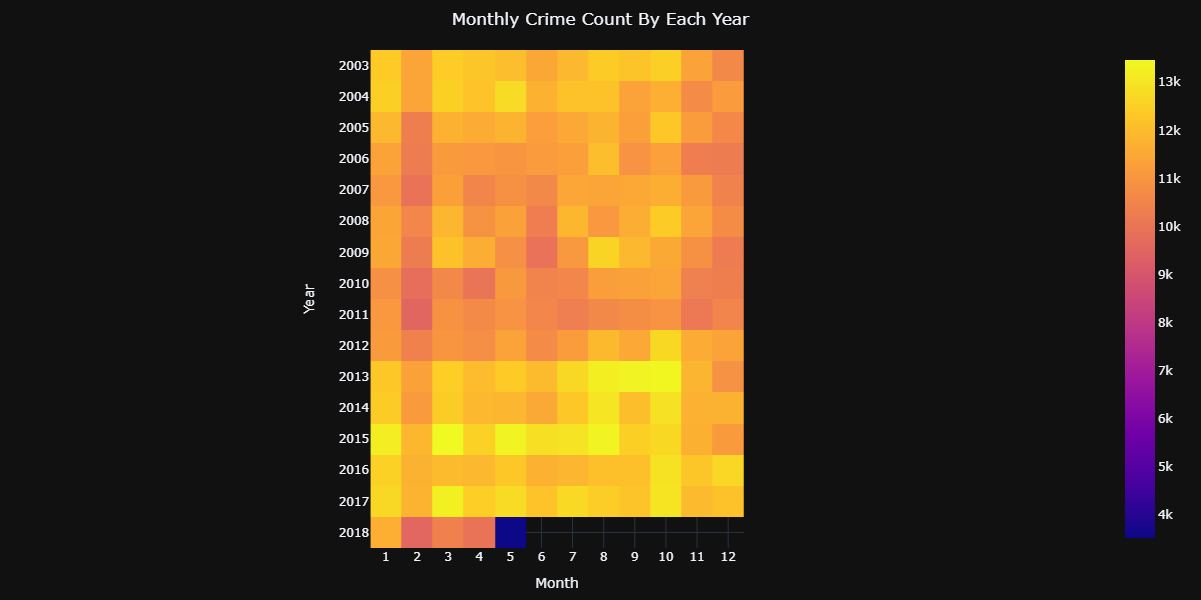

In [80]:
# Create heatmap with year, month and count
fig = px.imshow(df_monthly.pivot("year", "month", "count"), width=800, height=600)
fig.update_layout(
    template='plotly_dark',
    title=dict(
        text='Monthly Crime Count By Each Year',
        x=0.5
    ),
    xaxis=dict(
            title='Month',
            tickmode='linear'),
    yaxis=dict(
            title='Year',
            tickmode='linear'),
    margin=dict(l=20, r=20, t=50, b=20)
)
fig.show()

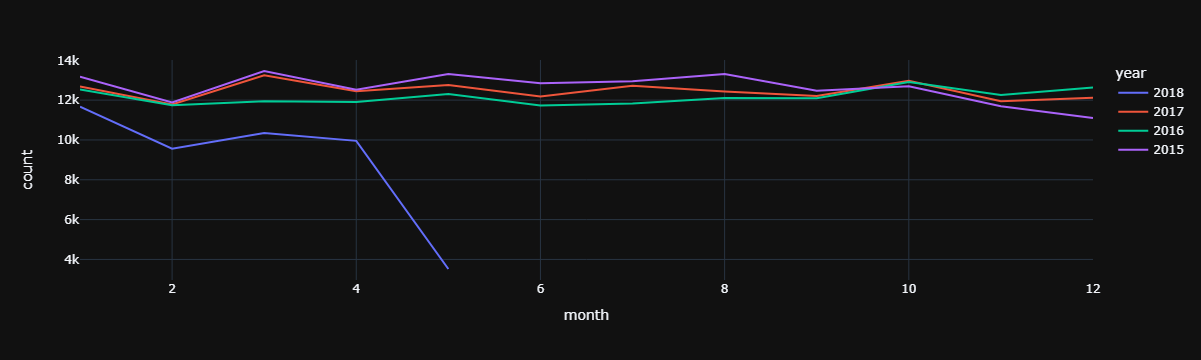

In [91]:
# fig = px.line(df_monthly[(df_monthly["year"] >= 2015) & (df_monthly["year"] <= 2018)], x="month", y="count", color='year')
fig = px.line(df_monthly[(df_monthly["year"] >= 2015) & (df_monthly["year"] <= 2018)], x="month", y="count", color="year")
fig.update_layout(template='plotly_dark')
fig.show()

### OLAP 1.5 
Analyze the number of crime w.r.t the hour in certian day like 2015/12/15, 2016/12/15, 2017/12/15. Provide travel suggestion to visit SF.

In [95]:
# Filter data by dates
dates = ['2015-12-15','2016-12-15','2017-12-15']
df_hour = df[df['Date'].isin(dates)].withColumn("hour", hour(col("Time")))

In [99]:
# Prepare data for bar chart
df_data = df_hour.groupBy(col("Date").alias("date"), col("hour")) \
        .agg(count(lit(1)).alias("count")) \
        .sort(col("date").desc(), col("hour").desc()) \
        .toPandas()

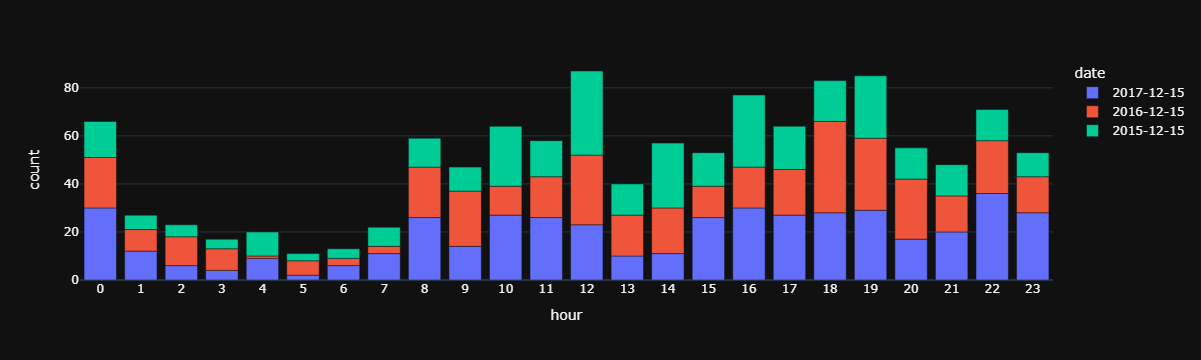

In [163]:
# Create bar chart for the 3 date by hour cirme count
fig = px.bar(df_data, x="hour", y="count", color="date")
fig.update_layout(template='plotly_dark', xaxis={"tickmode": "linear"})
fig.show()

### OLAP 1.6
1. Find out the top-3 danger disrict
2. Find out the crime event w.r.t category and time (hour) from the result of step 1
3. Give advice to distribute the police based on analysis results.

(1) Step1: Find out the top-3 danger disrict

In [105]:
danger_yearly = df.groupby(col("PdDistrict").alias("district"), year(col("Date")).alias("year")).count() \
                .sort(col("district").desc(), col("year").desc())

In [106]:
df_danger_yearly = danger_yearly.toPandas()

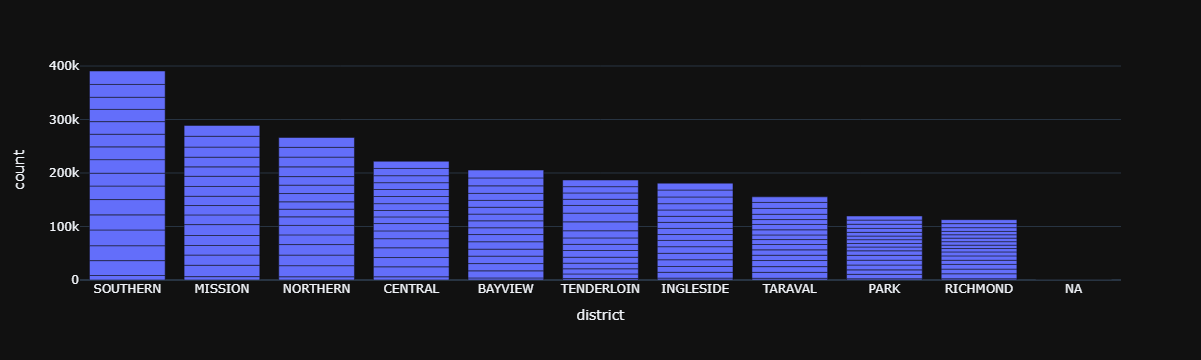

In [114]:
fig = px.bar(df_danger_yearly, x="district", y="count")
fig.update_layout(template='plotly_dark', barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

In [155]:
df_top_district = df_danger_yearly.groupby("district").agg({"count":["sum"]}).reset_index()

In [136]:
df_top_district.columns = ["district", "count"]

In [141]:
top3_values = df_top_district.sort_values(by="count", ascending=False).head(3)

In [156]:
top3_district = [top3_values.iloc[i,0] for i in range(3)]
top3_district

['SOUTHERN', 'MISSION', 'NORTHERN']

(2) Step2: find out the crime event w.r.t category and time (hour) from the result of step 1

In [160]:
df_crime_per_hr = df.filter(col("PdDistrict").isin(top3_district)) \
            .groupBy(col("PdDistrict").alias("district"), hour(col("Time")).alias("hour")) \
            .count() \
            .orderBy('district','hour') \
            .toPandas()

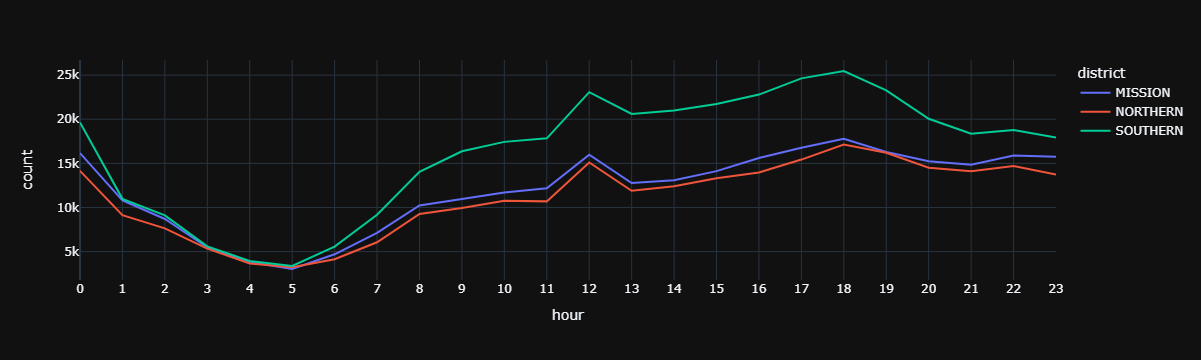

In [164]:
fig = px.line(df_crime_per_hr, x="hour", y="count", color="district")
fig.update_layout(template="plotly_dark", xaxis={"tickmode": "linear"})
fig.show()